In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [ ]:
df3 = pd.read_csv('gdp-per-capita/gdp-per-capita.csv', skiprows=4)
df3.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,27441.550214,28440.041688,30082.158423,30645.890602,22759.807175,26749.329609,30975.998912,35718.753119,39498.594129,NaN
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,186.089204,186.909053,197.367547,225.400079,208.962717,226.836135,...,1334.470500,1528.104224,1552.073722,1507.085600,1351.591669,1562.416175,1679.327622,1571.449189,1615.396356,NaN
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,522.082216,525.469771,491.337221,496.602504,510.787063,356.496214,357.261153,413.757895,NaN,NaN
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,121.936832,127.451040,133.823783,139.004980,148.545883,155.561897,...,1630.039439,1574.230564,1720.140092,2216.385055,2030.861659,2112.794076,2138.473153,1841.855064,1411.337029,NaN
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2051.814621,2790.718869,2860.093648,2493.678844,1759.356199,2303.908127,3682.113151,2916.136633,2665.874448,NaN


In [71]:


df4 = pd.read_csv('co-emissions-per-capita.filtered/co-emissions-per-capita.csv')

df4.head()

,Entity,Code,Year,Annual CO₂ emissions (per capita)
0,India,IND,1858,0.001631
1,India,IND,1859,0.002622
2,India,IND,1860,0.002641
3,India,IND,1861,0.002036
4,India,IND,1862,0.002246


In [73]:
# extract india gdp wide to long:
# Keep only India
india_gdp_pc = df3[df3['Country Name'] == 'India']

# india_gdp_pc.head()
# Drop metadata columns
india_gdp_pc = india_gdp_pc.drop(
    columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 69']
)

# Convert wide → long
india_gdp_pc = india_gdp_pc.melt(
    var_name='Year',
    value_name='GDP_pc'
)

# Clean year
india_gdp_pc['Year'] = india_gdp_pc['Year'].astype(int)

# Drop missing
india_gdp_pc = india_gdp_pc.dropna()

india_gdp_pc.head()



,Year,GDP_pc
0,1960,84.932808
1,1961,87.853861
2,1962,92.199958
3,1963,103.435021
4,1964,117.856431


In [74]:
# clean co2 per capita 

india_co2_pc = df4[df4['Entity'] == 'India'][['Year', 'Annual CO₂ emissions (per capita)']]
india_co2_pc = india_co2_pc.rename(
    columns={'Annual CO₂ emissions (per capita)': 'CO2_pc'}
)

india_co2_pc.head()



,Year,CO2_pc
0,1858,0.001631
1,1859,0.002622
2,1860,0.002641
3,1861,0.002036
4,1862,0.002246


In [75]:
# merge GDP and CO2 
ekc_pc_df = pd.merge(
    india_gdp_pc,
    india_co2_pc,
    on='Year',
    how='inner'
)

ekc_pc_df.shape
ekc_pc_df.head()



,Year,GDP_pc,CO2_pc
0,1960,84.932808,0.255327
1,1961,87.853861,0.269612
2,1962,92.199958,0.289929
3,1963,103.435021,0.304267
4,1964,117.856431,0.291057


In [76]:


ekc_pc_df['ln_GDP_pc'] = np.log(ekc_pc_df['GDP_pc'])
ekc_pc_df['ln_CO2_pc'] = np.log(ekc_pc_df['CO2_pc'])

ekc_pc_df['ln_GDP_pc_sq'] = ekc_pc_df['ln_GDP_pc'] ** 2


In [77]:
# add time trend 

ekc_pc_df = ekc_pc_df.sort_values('Year')
ekc_pc_df['trend'] = np.arange(1, len(ekc_pc_df) + 1)


In [86]:
# ekc regression 

X = ekc_pc_df[['ln_GDP_pc', 'ln_GDP_pc_sq']]
X = sm.add_constant(X)

model = sm.OLS(ekc_pc_df['ln_CO2_pc'], X).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:              ln_CO2_pc   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     895.7
Date:                Tue, 27 Jan 2026   Prob (F-statistic):           1.81e-46
Time:                        21:39:39   Log-Likelihood:                 46.598
No. Observations:                  65   AIC:                            -87.20
Df Residuals:                      62   BIC:                            -80.67
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.7370      0.568     -8.333   

In [83]:
ekc_pc_df[['ln_GDP_pc', 'trend']].corr()


,ln_GDP_pc,trend
ln_GDP_pc,1.000000,0.984004
trend,0.984004,1.000000


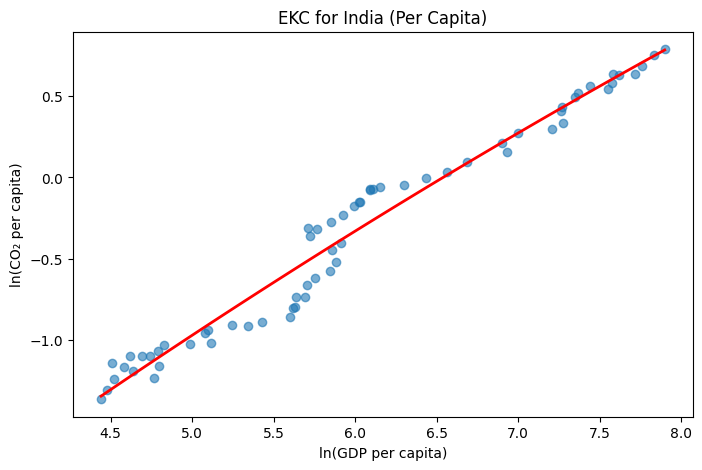

In [88]:
# visualize ekc

gdp_range = np.linspace(
    ekc_pc_df['ln_GDP_pc'].min(),
    ekc_pc_df['ln_GDP_pc'].max(),
    100
)

trend_mean = ekc_pc_df['trend'].mean()

ln_co2_hat = (
    model.params['const']
    + model.params['ln_GDP_pc'] * gdp_range
    + model.params['ln_GDP_pc_sq'] * gdp_range**2
)

plt.figure(figsize=(8,5))
plt.scatter(ekc_pc_df['ln_GDP_pc'], ekc_pc_df['ln_CO2_pc'], alpha=0.6)
plt.plot(gdp_range, ln_co2_hat, color='red', linewidth=2)

plt.xlabel('ln(GDP per capita)')
plt.ylabel('ln(CO₂ per capita)')
plt.title('EKC for India (Per Capita)')
plt.show()
